In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Regression Modules
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor

#tuing model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.preprocessing import StandardScaler

#data split
from sklearn.model_selection import train_test_split


In [14]:
#importing train and test data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [16]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [20]:
remove_list1=["Id"]
for i in train_df.columns.tolist():
    if train_df[i].isnull().sum() >= 500:
        print(i,train_df[i].isnull().sum())
        remove_list1.append(i)

Alley 1369
MasVnrType 872
FireplaceQu 690
PoolQC 1453
Fence 1179
MiscFeature 1406


In [22]:
train_df = train_df.drop(columns=remove_list1)
test_df = test_df.drop(columns=remove_list1)

In [24]:
object_columns = train_df.select_dtypes(include=['object']).columns.tolist()
print(object_columns)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [26]:
for i in object_columns:
    frequency = train_df[i].value_counts(normalize=True)  # Normalize to get frequency ratio
    train_df[str(i)+'_encoded'] = train_df[i].map(frequency)
for i in object_columns:
    train_df = train_df.drop(columns = [i])

In [28]:
object_columns = test_df.select_dtypes(include=['object']).columns.tolist()
for i in object_columns:
    frequency = test_df[i].value_counts(normalize=True)  # Normalize to get frequency ratio
    test_df[str(i)+'_encoded'] = test_df[i].map(frequency)
for i in object_columns:
    test_df = test_df.drop(columns = [i])

In [30]:
per_df = pd.DataFrame()
for i in range(len(train_df)):
    if train_df.iloc[i].isnull().sum() == 0:
        per_df = per_df._append(train_df.iloc[i], ignore_index=True)

In [32]:
per_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Electrical_encoded,KitchenQual_encoded,Functional_encoded,GarageType_encoded,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,0.914325,0.503425,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.914325,0.401370,0.931507,0.280638,0.438724,0.950689,0.961566,0.917808,0.867808,0.069178
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548


In [34]:
per_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 74 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MSSubClass             1094 non-null   float64
 1   LotFrontage            1094 non-null   float64
 2   LotArea                1094 non-null   float64
 3   OverallQual            1094 non-null   float64
 4   OverallCond            1094 non-null   float64
 5   YearBuilt              1094 non-null   float64
 6   YearRemodAdd           1094 non-null   float64
 7   MasVnrArea             1094 non-null   float64
 8   BsmtFinSF1             1094 non-null   float64
 9   BsmtFinSF2             1094 non-null   float64
 10  BsmtUnfSF              1094 non-null   float64
 11  TotalBsmtSF            1094 non-null   float64
 12  1stFlrSF               1094 non-null   float64
 13  2ndFlrSF               1094 non-null   float64
 14  LowQualFinSF           1094 non-null   float64
 15  GrLi

In [36]:
per_test_df = per_df.drop(columns=['SalePrice'])
per_test_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Electrical_encoded,KitchenQual_encoded,Functional_encoded,GarageType_encoded,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,0.914325,0.503425,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.914325,0.401370,0.931507,0.280638,0.438724,0.950689,0.961566,0.917808,0.867808,0.069178
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548


In [38]:
per_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 73 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MSSubClass             1094 non-null   float64
 1   LotFrontage            1094 non-null   float64
 2   LotArea                1094 non-null   float64
 3   OverallQual            1094 non-null   float64
 4   OverallCond            1094 non-null   float64
 5   YearBuilt              1094 non-null   float64
 6   YearRemodAdd           1094 non-null   float64
 7   MasVnrArea             1094 non-null   float64
 8   BsmtFinSF1             1094 non-null   float64
 9   BsmtFinSF2             1094 non-null   float64
 10  BsmtUnfSF              1094 non-null   float64
 11  TotalBsmtSF            1094 non-null   float64
 12  1stFlrSF               1094 non-null   float64
 13  2ndFlrSF               1094 non-null   float64
 14  LowQualFinSF           1094 non-null   float64
 15  GrLi

In [40]:
train_null_columns = []
train_null_sum = []
for i in range(len(train_df)):
    if train_df.iloc[i].isnull().sum() > 0:
        train_null_columns.append(i)
        train_null_sum.append(train_df.iloc[i].isnull().sum())

In [42]:
per_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Electrical_encoded,KitchenQual_encoded,Functional_encoded,GarageType_encoded,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,0.914325,0.503425,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.914325,0.401370,0.931507,0.280638,0.438724,0.950689,0.961566,0.917808,0.867808,0.069178
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,0.0,...,0.914325,0.503425,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
1090,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,163.0,...,0.914325,0.503425,0.021233,0.630892,0.438724,0.950689,0.961566,0.917808,0.867808,0.820548
1091,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
1092,20.0,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,1029.0,...,0.064428,0.401370,0.931507,0.630892,0.438724,0.950689,0.961566,0.917808,0.867808,0.820548


In [44]:
print("Row with Null Values are :",train_null_columns,end=" ")
print("The Number of Null Values are :",train_null_sum,end=" ")

Row with Null Values are : [7, 12, 14, 16, 17, 24, 31, 39, 42, 43, 48, 50, 64, 66, 76, 78, 84, 88, 89, 90, 95, 99, 100, 102, 104, 108, 111, 113, 116, 120, 125, 126, 127, 131, 133, 136, 140, 147, 148, 149, 152, 153, 155, 156, 160, 163, 165, 166, 169, 170, 177, 180, 182, 186, 191, 198, 203, 207, 208, 210, 214, 218, 221, 234, 237, 241, 244, 249, 250, 259, 269, 287, 288, 291, 293, 307, 308, 310, 319, 328, 330, 332, 335, 342, 346, 347, 351, 356, 360, 361, 362, 364, 366, 369, 370, 371, 375, 384, 386, 392, 393, 404, 405, 412, 421, 426, 431, 434, 441, 447, 452, 457, 458, 459, 464, 465, 470, 484, 490, 495, 496, 516, 518, 520, 528, 529, 532, 533, 535, 537, 538, 539, 541, 545, 553, 559, 560, 562, 564, 569, 580, 582, 593, 610, 611, 612, 613, 614, 616, 620, 623, 626, 635, 636, 638, 641, 645, 646, 649, 650, 660, 666, 668, 672, 679, 682, 685, 687, 690, 705, 706, 709, 710, 714, 720, 721, 726, 734, 736, 738, 745, 746, 749, 750, 751, 757, 770, 778, 783, 784, 785, 789, 791, 794, 811, 816, 817, 822, 826, 

In [46]:
def fill_null_val(per,df):
    filled_df = df.copy()

    null_columns = []
    null_sum = []
    for i in range(len(filled_df)):
        if filled_df.iloc[i].isnull().sum() > 0:
            null_columns.append(i)
            null_sum.append(filled_df.iloc[i].isnull().sum())
    for t in null_columns:
        d_f = filled_df.copy()
        result = d_f.iloc[t].isnull()
        null_columns_name = result[result].index.tolist()

        # train model - use per_df data
        y = pd.DataFrame(per[null_columns_name])
        X = pd.DataFrame(per.drop(columns=null_columns_name))
        model = MultiOutputRegressor(LinearRegression())

        # create model
        model.fit(X, y)
        # insert to actual data - from train/test data
        X_test = pd.DataFrame(d_f.loc[t])

        # generate to dataframe
        result_df = pd.DataFrame(X_test, columns=X_test.columns)

        # exchange column - index
        X_test = result_df.T
        X_test = X_test.drop(columns=null_columns_name)

        y_pred = model.predict(X_test)

        for i in range(len(null_columns_name)):
            d_f.loc[t, null_columns_name[i]] = y_pred.tolist()[0][i]
            filled_df = d_f.copy()
    
    return filled_df

In [48]:
filled_train_df = fill_null_val(per_df,train_df)
print(filled_train_df)

      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFin

In [52]:
per_test_df = per_df.copy()
column_to_move = 'SalePrice'

new_order = [col for col in per_test_df.columns if col != column_to_move] + [column_to_move]
per_test_df = per_test_df[new_order]
per_test_df = per_test_df.iloc[:,:-1]


In [54]:
per_test_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Electrical_encoded,KitchenQual_encoded,Functional_encoded,GarageType_encoded,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,0.914325,0.503425,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.914325,0.401370,0.931507,0.280638,0.438724,0.950689,0.961566,0.917808,0.867808,0.069178
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,0.0,...,0.914325,0.503425,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
1090,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,163.0,...,0.914325,0.503425,0.021233,0.630892,0.438724,0.950689,0.961566,0.917808,0.867808,0.820548
1091,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
1092,20.0,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,1029.0,...,0.064428,0.401370,0.931507,0.630892,0.438724,0.950689,0.961566,0.917808,0.867808,0.820548


In [56]:
filled_test_df = fill_null_val(per_test_df,test_df)
print(filled_test_df)

      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             20         80.0    11622            5            6       1961   
1             20         81.0    14267            6            6       1958   
2             60         74.0    13830            5            5       1997   
3             60         78.0     9978            6            6       1998   
4            120         43.0     5005            8            5       1992   
...          ...          ...      ...          ...          ...        ...   
1454         160         21.0     1936            4            7       1970   
1455         160         21.0     1894            4            5       1970   
1456          20        160.0    20000            5            7       1960   
1457          85         62.0    10441            5            5       1992   
1458          60         74.0     9627            7            5       1993   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFin

In [60]:
def features_(filled_train_df):
    filled_train_df['TotalBathArea'] = filled_train_df['FullBath'] + 0.5 * filled_train_df['HalfBath']
    filled_train_df['TotalBathroomArea'] = filled_train_df['FullBath'] + 0.5 * filled_train_df['HalfBath']
    outdoor_features = ['WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch']
    filled_train_df['TotalOutdoorArea'] = filled_train_df[outdoor_features].sum(axis=1)
    basement_features = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
    filled_train_df['TotalBasementArea'] = filled_train_df[basement_features].sum(axis=1)

for i in [filled_train_df,filled_test_df,per_df]:
    features_(i)
filled_train_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded,TotalBathArea,TotalBathroomArea,TotalOutdoorArea,TotalBasementArea
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,61,1712
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548,2.0,2.0,298,2524
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,42,1840
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0.438724,0.950689,0.961566,0.917808,0.867808,0.069178,1.0,1.0,35,1512
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,276,2290


In [62]:
filled_train_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded,TotalBathArea,TotalBathroomArea,TotalOutdoorArea,TotalBasementArea
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,61,1712
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548,2.0,2.0,298,2524
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,42,1840
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0.438724,0.950689,0.961566,0.917808,0.867808,0.069178,1.0,1.0,35,1512
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,276,2290


In [64]:
filled_test_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded,TotalBathArea,TotalBathroomArea,TotalOutdoorArea,TotalBasementArea
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0.452571,0.936278,0.961622,0.891707,0.862826,0.825223,1.0,1.0,260,1764.0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0.452571,0.936278,0.961622,0.891707,0.862826,0.825223,1.5,1.5,429,2658.0
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0.265749,0.936278,0.961622,0.891707,0.862826,0.825223,2.5,2.5,246,1856.0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0.265749,0.936278,0.961622,0.891707,0.862826,0.825223,2.5,2.5,396,1852.0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,0.281680,0.936278,0.961622,0.891707,0.862826,0.825223,2.0,2.0,226,2560.0


In [66]:
per_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded,TotalBathArea,TotalBathroomArea,TotalOutdoorArea,TotalBasementArea
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,61.0,1712.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548,2.0,2.0,298.0,2524.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,42.0,1840.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.438724,0.950689,0.961566,0.917808,0.867808,0.069178,1.0,1.0,35.0,1512.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,276.0,2290.0


<Axes: title={'center': 'Person Correlation of Features'}>

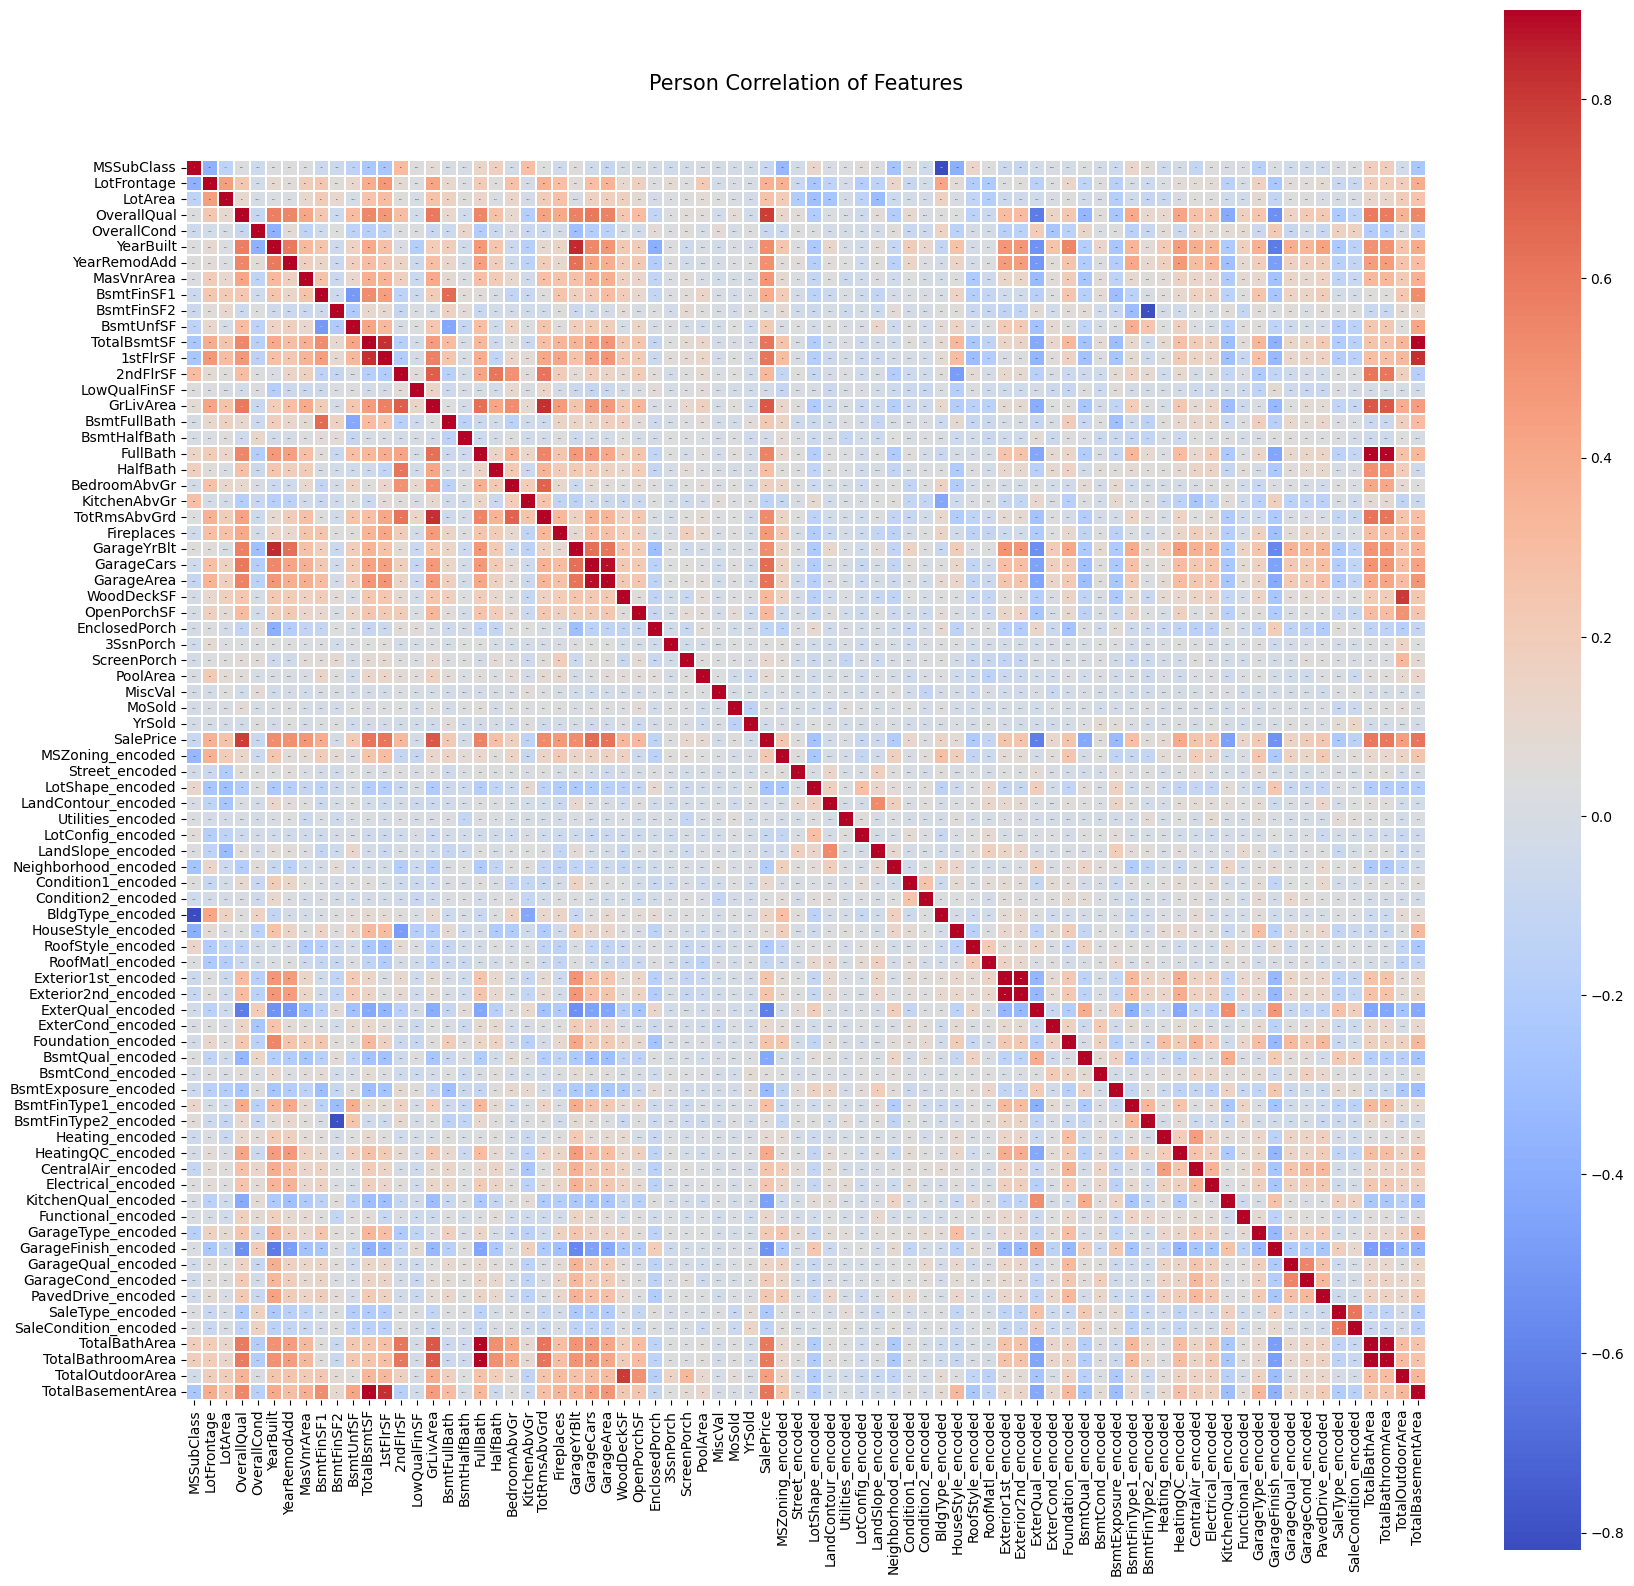

In [68]:
colormap = plt.cm.PuBu
plt.figure(figsize=(20, 20))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
sns.heatmap(filled_train_df.astype(float).corr(), linewidths = 0.2, vmax = 0.9,
           square = True, cmap = "coolwarm", linecolor = "white", annot = True, annot_kws = {"size" : 0})

In [70]:
corr = per_df.corr(method ="pearson")
sp_corr = corr.iloc[corr.index.tolist().index("SalePrice")].values.tolist()
left_col = []
for i in range(len(sp_corr)):
    if type(sp_corr[i]) == float:
        if sp_corr[i] >= 0.25:
            left_col.append(corr.index[i])
print(left_col,end = " ")

['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice', 'Exterior1st_encoded', 'Exterior2nd_encoded', 'BsmtFinType1_encoded', 'HeatingQC_encoded', 'TotalBathArea', 'TotalBathroomArea', 'TotalOutdoorArea', 'TotalBasementArea'] 

In [72]:
corr = per_df.corr(method ="pearson")
sp_corr = corr.iloc[corr.index.tolist().index("SalePrice")].values.tolist()
left_col = []
for i in range(len(sp_corr)):
    if type(sp_corr[i]) == float:
        if sp_corr[i] >= 0.25:
            left_col.append(corr.index[i])
print(left_col,end = " ")

['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice', 'Exterior1st_encoded', 'Exterior2nd_encoded', 'BsmtFinType1_encoded', 'HeatingQC_encoded', 'TotalBathArea', 'TotalBathroomArea', 'TotalOutdoorArea', 'TotalBasementArea'] 

In [74]:
new_df = filled_train_df[left_col]

column_to_move = 'SalePrice'

new_order = [col for col in new_df.columns if col != column_to_move] + [column_to_move]
new_df = new_df[new_order]

(new_df)

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,OpenPorchSF,Exterior1st_encoded,Exterior2nd_encoded,BsmtFinType1_encoded,HeatingQC_encoded,TotalBathArea,TotalBathroomArea,TotalOutdoorArea,TotalBasementArea,SalePrice
0,65.0,8450,7,2003,2003,196.0,706,856,856,854,...,61,0.352740,0.345205,0.293746,0.507534,2.5,2.5,61,1712,208500
1,80.0,9600,6,1976,1976,0.0,978,1262,1262,0,...,0,0.150685,0.146575,0.154603,0.507534,2.0,2.0,298,2524,181500
2,68.0,11250,7,2001,2002,162.0,486,920,920,866,...,42,0.352740,0.345205,0.293746,0.507534,2.5,2.5,42,1840,223500
3,60.0,9550,7,1915,1970,0.0,216,756,961,756,...,35,0.141096,0.026027,0.154603,0.165068,1.0,1.0,35,1512,140000
4,84.0,14260,8,2000,2000,350.0,655,1145,1145,1053,...,84,0.352740,0.345205,0.293746,0.507534,2.5,2.5,276,2290,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,6,1999,2000,0.0,0,953,953,694,...,40,0.352740,0.345205,0.302178,0.507534,2.5,2.5,40,1906,175000
1456,85.0,13175,6,1978,1988,119.0,790,1542,2073,0,...,0,0.073973,0.097260,0.154603,0.293151,2.0,2.0,349,3084,210000
1457,66.0,9042,7,1941,2006,0.0,275,1152,1188,1152,...,60,0.041781,0.041096,0.293746,0.507534,2.0,2.0,60,2304,266500
1458,68.0,9717,5,1950,1996,0.0,49,1078,1078,0,...,0,0.150685,0.146575,0.293746,0.165068,1.0,1.0,366,2156,142125


In [76]:
column_to_move = 'SalePrice'

new_order = [col for col in filled_train_df.columns if col != column_to_move] + [column_to_move]
filled_train_df = filled_train_df[new_order]

(filled_train_df)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded,TotalBathArea,TotalBathroomArea,TotalOutdoorArea,TotalBasementArea,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,61,1712,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0.950689,0.961566,0.917808,0.867808,0.820548,2.0,2.0,298,2524,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,42,1840,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0.950689,0.961566,0.917808,0.867808,0.069178,1.0,1.0,35,1512,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,276,2290,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,40,1906,175000
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0.950689,0.961566,0.917808,0.867808,0.820548,2.0,2.0,349,3084,210000
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0.950689,0.961566,0.917808,0.867808,0.820548,2.0,2.0,60,2304,266500
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0.950689,0.961566,0.917808,0.867808,0.820548,1.0,1.0,366,2156,142125


In [78]:
column_to_move = 'SalePrice'

new_order = [col for col in per_df.columns if col != column_to_move] + [column_to_move]
per_df = per_df[new_order]

per_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded,TotalBathArea,TotalBathroomArea,TotalOutdoorArea,TotalBasementArea,SalePrice
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,61.0,1712.0,208500.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,0.950689,0.961566,0.917808,0.867808,0.820548,2.0,2.0,298.0,2524.0,181500.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,42.0,1840.0,223500.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.950689,0.961566,0.917808,0.867808,0.069178,1.0,1.0,35.0,1512.0,140000.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,276.0,2290.0,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,0.0,...,0.950689,0.961566,0.917808,0.867808,0.820548,2.5,2.5,40.0,1906.0,175000.0
1090,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,163.0,...,0.950689,0.961566,0.917808,0.867808,0.820548,2.0,2.0,349.0,3084.0,210000.0
1091,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,0.0,...,0.950689,0.961566,0.917808,0.867808,0.820548,2.0,2.0,60.0,2304.0,266500.0
1092,20.0,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,1029.0,...,0.950689,0.961566,0.917808,0.867808,0.820548,1.0,1.0,366.0,2156.0,142125.0


In [82]:
data_frames = [new_df, per_df, filled_train_df]
scaler = StandardScaler()
for i in range(len(data_frames)):
  data_frames[i] = scaler.fit_transform(data_frames[i])

new_df


,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,OpenPorchSF,Exterior1st_encoded,Exterior2nd_encoded,BsmtFinType1_encoded,HeatingQC_encoded,TotalBathArea,TotalBathroomArea,TotalOutdoorArea,TotalBasementArea,SalePrice
0,65.0,8450,7,2003,2003,196.0,706,856,856,854,...,61,0.352740,0.345205,0.293746,0.507534,2.5,2.5,61,1712,208500
1,80.0,9600,6,1976,1976,0.0,978,1262,1262,0,...,0,0.150685,0.146575,0.154603,0.507534,2.0,2.0,298,2524,181500
2,68.0,11250,7,2001,2002,162.0,486,920,920,866,...,42,0.352740,0.345205,0.293746,0.507534,2.5,2.5,42,1840,223500
3,60.0,9550,7,1915,1970,0.0,216,756,961,756,...,35,0.141096,0.026027,0.154603,0.165068,1.0,1.0,35,1512,140000
4,84.0,14260,8,2000,2000,350.0,655,1145,1145,1053,...,84,0.352740,0.345205,0.293746,0.507534,2.5,2.5,276,2290,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,6,1999,2000,0.0,0,953,953,694,...,40,0.352740,0.345205,0.302178,0.507534,2.5,2.5,40,1906,175000
1456,85.0,13175,6,1978,1988,119.0,790,1542,2073,0,...,0,0.073973,0.097260,0.154603,0.293151,2.0,2.0,349,3084,210000
1457,66.0,9042,7,1941,2006,0.0,275,1152,1188,1152,...,60,0.041781,0.041096,0.293746,0.507534,2.0,2.0,60,2304,266500
1458,68.0,9717,5,1950,1996,0.0,49,1078,1078,0,...,0,0.150685,0.146575,0.293746,0.165068,1.0,1.0,366,2156,142125


In [84]:
new_df = new_df.loc[:, ['TotalBathArea', 'TotalBathroomArea','TotalOutdoorArea','TotalBasementArea','SalePrice']]
print(new_df)

      TotalBathArea  TotalBathroomArea  TotalOutdoorArea  TotalBasementArea  \
0               2.5                2.5                61               1712   
1               2.0                2.0               298               2524   
2               2.5                2.5                42               1840   
3               1.0                1.0                35               1512   
4               2.5                2.5               276               2290   
...             ...                ...               ...                ...   
1455            2.5                2.5                40               1906   
1456            2.0                2.0               349               3084   
1457            2.0                2.0                60               2304   
1458            1.0                1.0               366               2156   
1459            1.5                1.5               804               2512   

      SalePrice  
0        208500  
1        181500

In [86]:
per_df = per_df.loc[:, ['TotalBathArea', 'TotalBathroomArea','TotalOutdoorArea','TotalBasementArea','SalePrice']]
print(per_df)

      TotalBathArea  TotalBathroomArea  TotalOutdoorArea  TotalBasementArea  \
0               2.5                2.5              61.0             1712.0   
1               2.0                2.0             298.0             2524.0   
2               2.5                2.5              42.0             1840.0   
3               1.0                1.0              35.0             1512.0   
4               2.5                2.5             276.0             2290.0   
...             ...                ...               ...                ...   
1089            2.5                2.5              40.0             1906.0   
1090            2.0                2.0             349.0             3084.0   
1091            2.0                2.0              60.0             2304.0   
1092            1.0                1.0             366.0             2156.0   
1093            1.5                1.5             804.0             2512.0   

      SalePrice  
0      208500.0  
1      181500.0

In [88]:
filled_train_df = filled_train_df.loc[:, ['TotalBathArea', 'TotalBathroomArea','TotalOutdoorArea','TotalBasementArea','SalePrice']]
print(filled_train_df)

      TotalBathArea  TotalBathroomArea  TotalOutdoorArea  TotalBasementArea  \
0               2.5                2.5                61               1712   
1               2.0                2.0               298               2524   
2               2.5                2.5                42               1840   
3               1.0                1.0                35               1512   
4               2.5                2.5               276               2290   
...             ...                ...               ...                ...   
1455            2.5                2.5                40               1906   
1456            2.0                2.0               349               3084   
1457            2.0                2.0                60               2304   
1458            1.0                1.0               366               2156   
1459            1.5                1.5               804               2512   

      SalePrice  
0        208500  
1        181500

In [90]:
filled_test_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded,TotalBathArea,TotalBathroomArea,TotalOutdoorArea,TotalBasementArea
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0.452571,0.936278,0.961622,0.891707,0.862826,0.825223,1.0,1.0,260,1764.0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0.452571,0.936278,0.961622,0.891707,0.862826,0.825223,1.5,1.5,429,2658.0
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0.265749,0.936278,0.961622,0.891707,0.862826,0.825223,2.5,2.5,246,1856.0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0.265749,0.936278,0.961622,0.891707,0.862826,0.825223,2.5,2.5,396,1852.0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,0.281680,0.936278,0.961622,0.891707,0.862826,0.825223,2.0,2.0,226,2560.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,0.433491,0.865288,0.922705,0.891707,0.862826,0.825223,1.5,1.5,0,1092.0
1455,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,0.452571,0.936278,0.961622,0.891707,0.862826,0.061001,1.5,1.5,24,1092.0
1456,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,0.452571,0.936278,0.961622,0.891707,0.862826,0.061001,1.0,1.0,474,2448.0
1457,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,0.370231,0.941486,0.901317,0.891707,0.862826,0.825223,1.0,1.0,112,1824.0


In [92]:
filled_test_df = filled_test_df.loc[:, ['TotalBathArea', 'TotalBathroomArea','TotalOutdoorArea','TotalBasementArea']]
print(filled_test_df)

      TotalBathArea  TotalBathroomArea  TotalOutdoorArea  TotalBasementArea
0               1.0                1.0               260             1764.0
1               1.5                1.5               429             2658.0
2               2.5                2.5               246             1856.0
3               2.5                2.5               396             1852.0
4               2.0                2.0               226             2560.0
...             ...                ...               ...                ...
1454            1.5                1.5                 0             1092.0
1455            1.5                1.5                24             1092.0
1456            1.0                1.0               474             2448.0
1457            1.0                1.0               112             1824.0
1458            2.5                2.5               238             1992.0

[1459 rows x 4 columns]


In [94]:
def differ_df_ml(df_type):
    import pandas as pd
    import numpy as np
    X = df_type.iloc[:,:-1]
    y = df_type.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    
    k_fold = KFold(n_splits = 9, shuffle=True, random_state = 0)

    lr_model = LinearRegression()
    rf_regressor = RandomForestRegressor(n_estimators=1000, random_state=42)
    cb_model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE')

    lr_model.fit(X_train, y_train)
    rf_regressor.fit(X_train, y_train)
    cb_model.fit(X_train, y_train, verbose=100)

    lr_pred = lr_model.predict(X_test)
    rf_pred = rf_regressor.predict(X_test)
    cb_pred = cb_model.predict(X_test)
        
    lr_mse = mean_squared_error(y_test, lr_pred)
    rf_mse = mean_squared_error(y_test, rf_pred)
    cb_mse = mean_squared_error(y_test, cb_pred)
    print(f'CB - RMSE: {cb_mse**0.5:.2f}')
    print(f'RF - RMSE: {rf_mse**0.5:.2f}')
    print(f'LR - RMSE: {lr_mse**0.5:.2f}')

In [96]:
differ_df_ml(filled_train_df)

0:	learn: 73689.5934678	total: 137ms	remaining: 2m 17s
100:	learn: 33834.4348869	total: 321ms	remaining: 2.86s
200:	learn: 29575.6460715	total: 484ms	remaining: 1.93s
300:	learn: 26537.8464292	total: 655ms	remaining: 1.52s
400:	learn: 24203.3978912	total: 821ms	remaining: 1.23s
500:	learn: 22353.7762103	total: 987ms	remaining: 983ms
600:	learn: 20981.5711169	total: 1.15s	remaining: 761ms
700:	learn: 19742.7319990	total: 1.31s	remaining: 560ms
800:	learn: 18690.6662202	total: 1.48s	remaining: 369ms
900:	learn: 17795.4600301	total: 1.64s	remaining: 180ms
999:	learn: 17012.1390735	total: 1.8s	remaining: 0us
CB - RMSE: 45679.37
RF - RMSE: 42800.79
LR - RMSE: 50626.54


In [98]:
differ_df_ml(per_df)

0:	learn: 78038.5535069	total: 1.71ms	remaining: 1.71s
100:	learn: 32684.7552577	total: 154ms	remaining: 1.37s
200:	learn: 27586.1004804	total: 313ms	remaining: 1.24s
300:	learn: 24520.5370642	total: 461ms	remaining: 1.07s
400:	learn: 22301.8810011	total: 616ms	remaining: 920ms
500:	learn: 20619.9074212	total: 775ms	remaining: 772ms
600:	learn: 19131.4662162	total: 931ms	remaining: 618ms
700:	learn: 17843.4413498	total: 1.08s	remaining: 460ms
800:	learn: 16685.2927680	total: 1.24s	remaining: 307ms
900:	learn: 15759.9812709	total: 1.4s	remaining: 153ms
999:	learn: 14961.3566718	total: 1.55s	remaining: 0us
CB - RMSE: 41345.76
RF - RMSE: 41643.07
LR - RMSE: 49687.37


In [100]:
differ_df_ml(new_df)

0:	learn: 73689.5934678	total: 2.69ms	remaining: 2.68s
100:	learn: 33834.4348869	total: 182ms	remaining: 1.62s
200:	learn: 29575.6460715	total: 354ms	remaining: 1.41s
300:	learn: 26537.8464292	total: 526ms	remaining: 1.22s
400:	learn: 24203.3978912	total: 698ms	remaining: 1.04s
500:	learn: 22353.7762103	total: 872ms	remaining: 868ms
600:	learn: 20981.5711169	total: 1.04s	remaining: 691ms
700:	learn: 19742.7319990	total: 1.21s	remaining: 516ms
800:	learn: 18690.6662202	total: 1.38s	remaining: 344ms
900:	learn: 17795.4600301	total: 1.55s	remaining: 171ms
999:	learn: 17012.1390735	total: 1.72s	remaining: 0us
CB - RMSE: 45679.37
RF - RMSE: 42800.79
LR - RMSE: 50626.54


In [102]:
new_X = new_df.iloc[:,:-1]
new_y = new_df.iloc[:,-1]

per_X = per_df.iloc[:,:-1]
per_y = per_df.iloc[:,-1]

ft_X = filled_train_df.iloc[:,:-1]
ft_y = filled_train_df.iloc[:,-1]

In [104]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=42)
per_X_train, per_X_test, per_y_train, per_y_test = train_test_split(per_X, per_y, test_size=0.2, random_state=42)
ft_X_train, ft_X_test, ft_y_train, ft_y_test = train_test_split(ft_X, ft_y, test_size=0.2, random_state=42)

In [106]:
new_rf_regressor = RandomForestRegressor(n_estimators=1000, random_state=42)
ft_rf_regressor = RandomForestRegressor(n_estimators=1000, random_state=42)
per_cb_model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE')

new_rf_regressor.fit(new_X_train, new_y_train)
ft_rf_regressor.fit(ft_X_train, ft_y_train)
per_cb_model.fit(per_X_train, per_y_train, verbose=100)

new_rf_pred = new_rf_regressor.predict(new_X_test)
ft_rf_pred = ft_rf_regressor.predict(ft_X_test)
per_cb_pred = per_cb_model.predict(per_X_test)

0:	learn: 77724.4738747	total: 2.07ms	remaining: 2.07s
100:	learn: 32124.1797899	total: 158ms	remaining: 1.41s
200:	learn: 27252.0665221	total: 314ms	remaining: 1.25s
300:	learn: 23781.6919096	total: 479ms	remaining: 1.11s
400:	learn: 21507.2497244	total: 636ms	remaining: 950ms
500:	learn: 19698.1285063	total: 795ms	remaining: 792ms
600:	learn: 18287.4002548	total: 956ms	remaining: 635ms
700:	learn: 17115.2618638	total: 1.12s	remaining: 476ms
800:	learn: 16038.2850969	total: 1.28s	remaining: 318ms
900:	learn: 15101.3877301	total: 1.44s	remaining: 158ms
999:	learn: 14339.7563117	total: 1.6s	remaining: 0us


In [113]:
name_list = ["new_rf","ft_rf","per_cb"]
ml_list = [new_rf_pred,ft_rf_pred,per_cb_pred]
test_list = [new_y_test,ft_y_test,per_y_test]

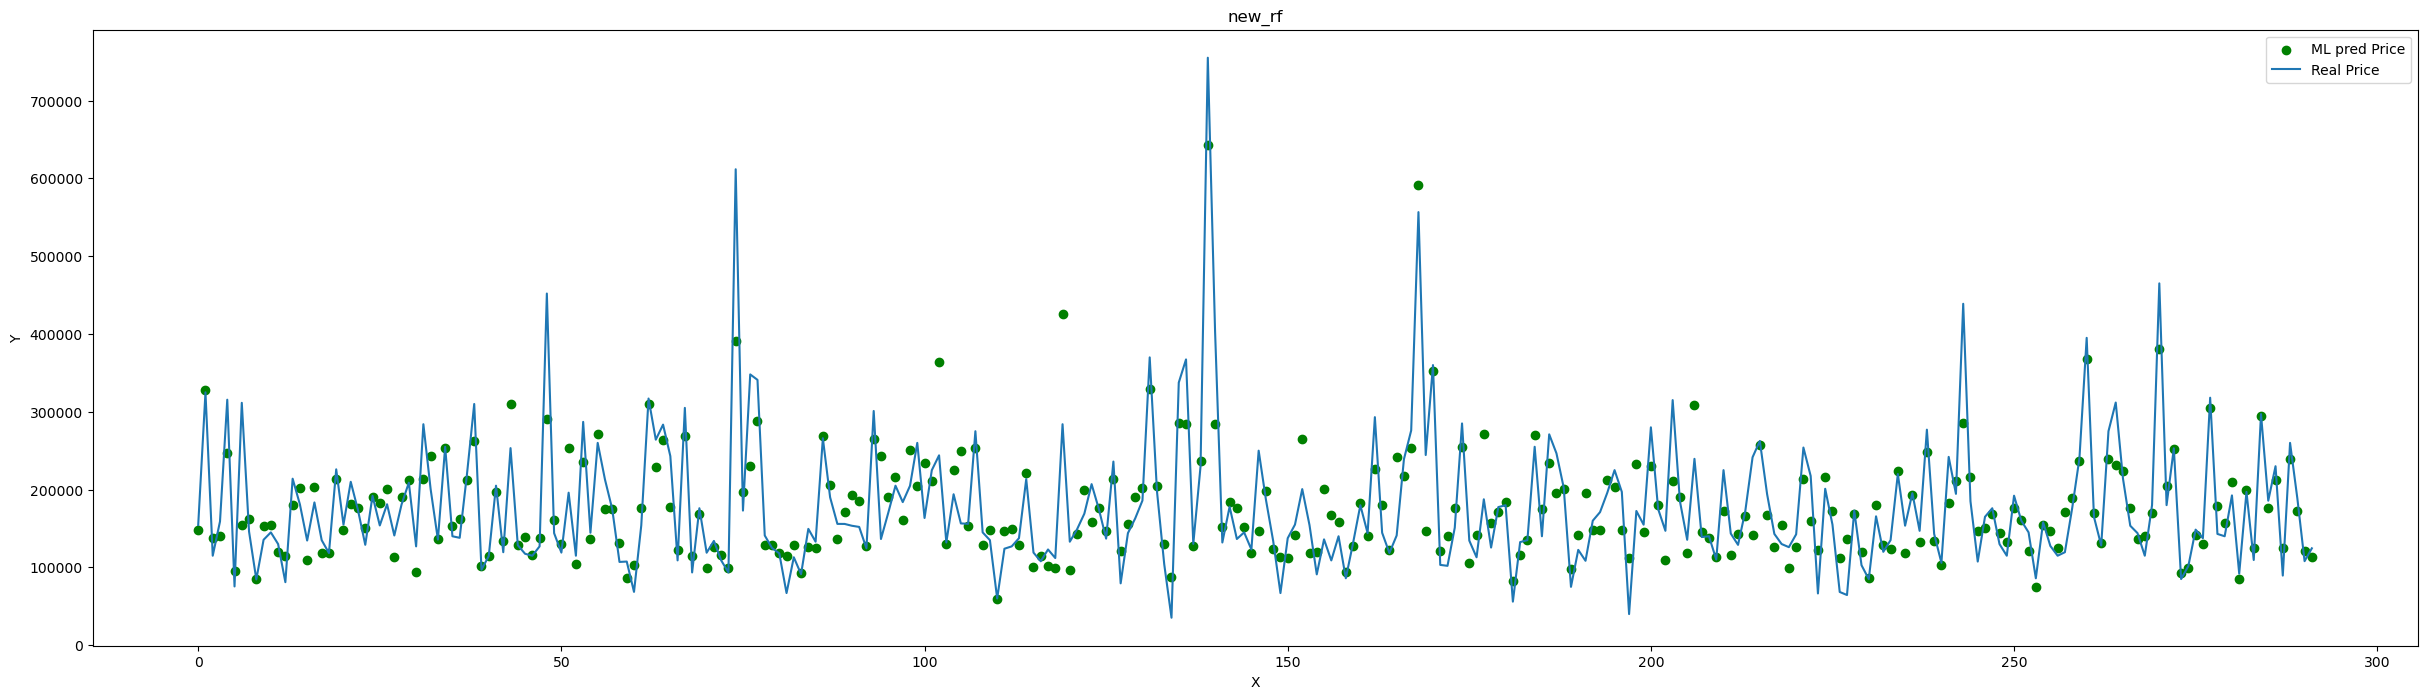

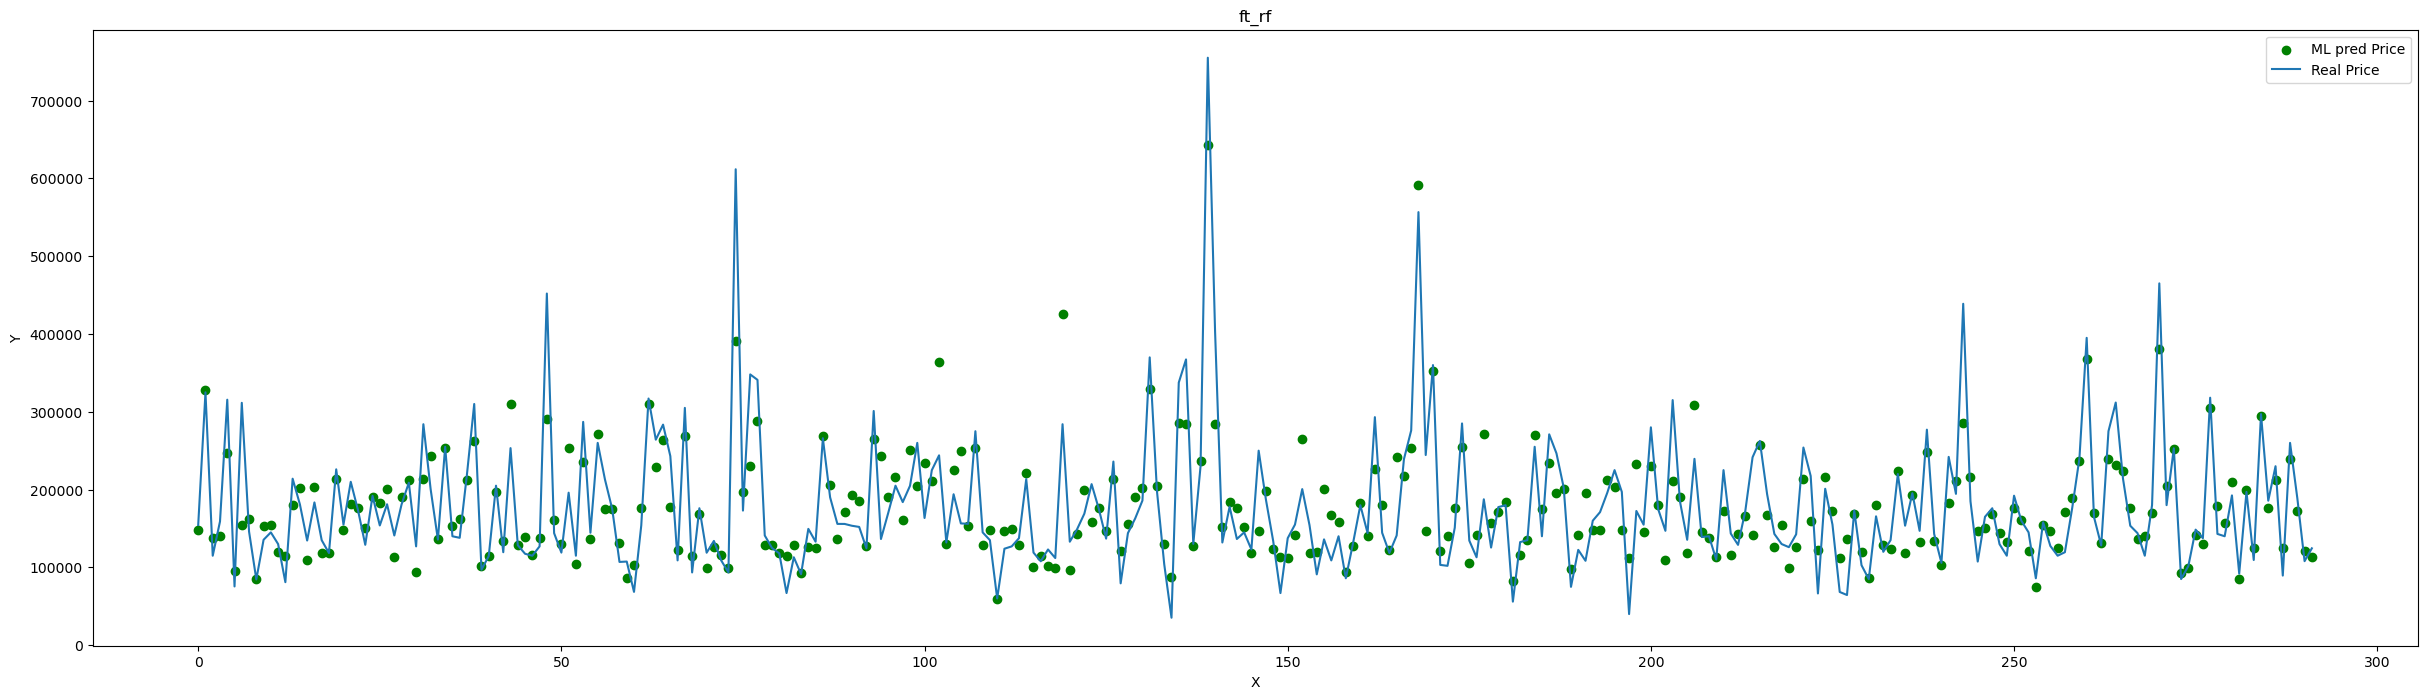

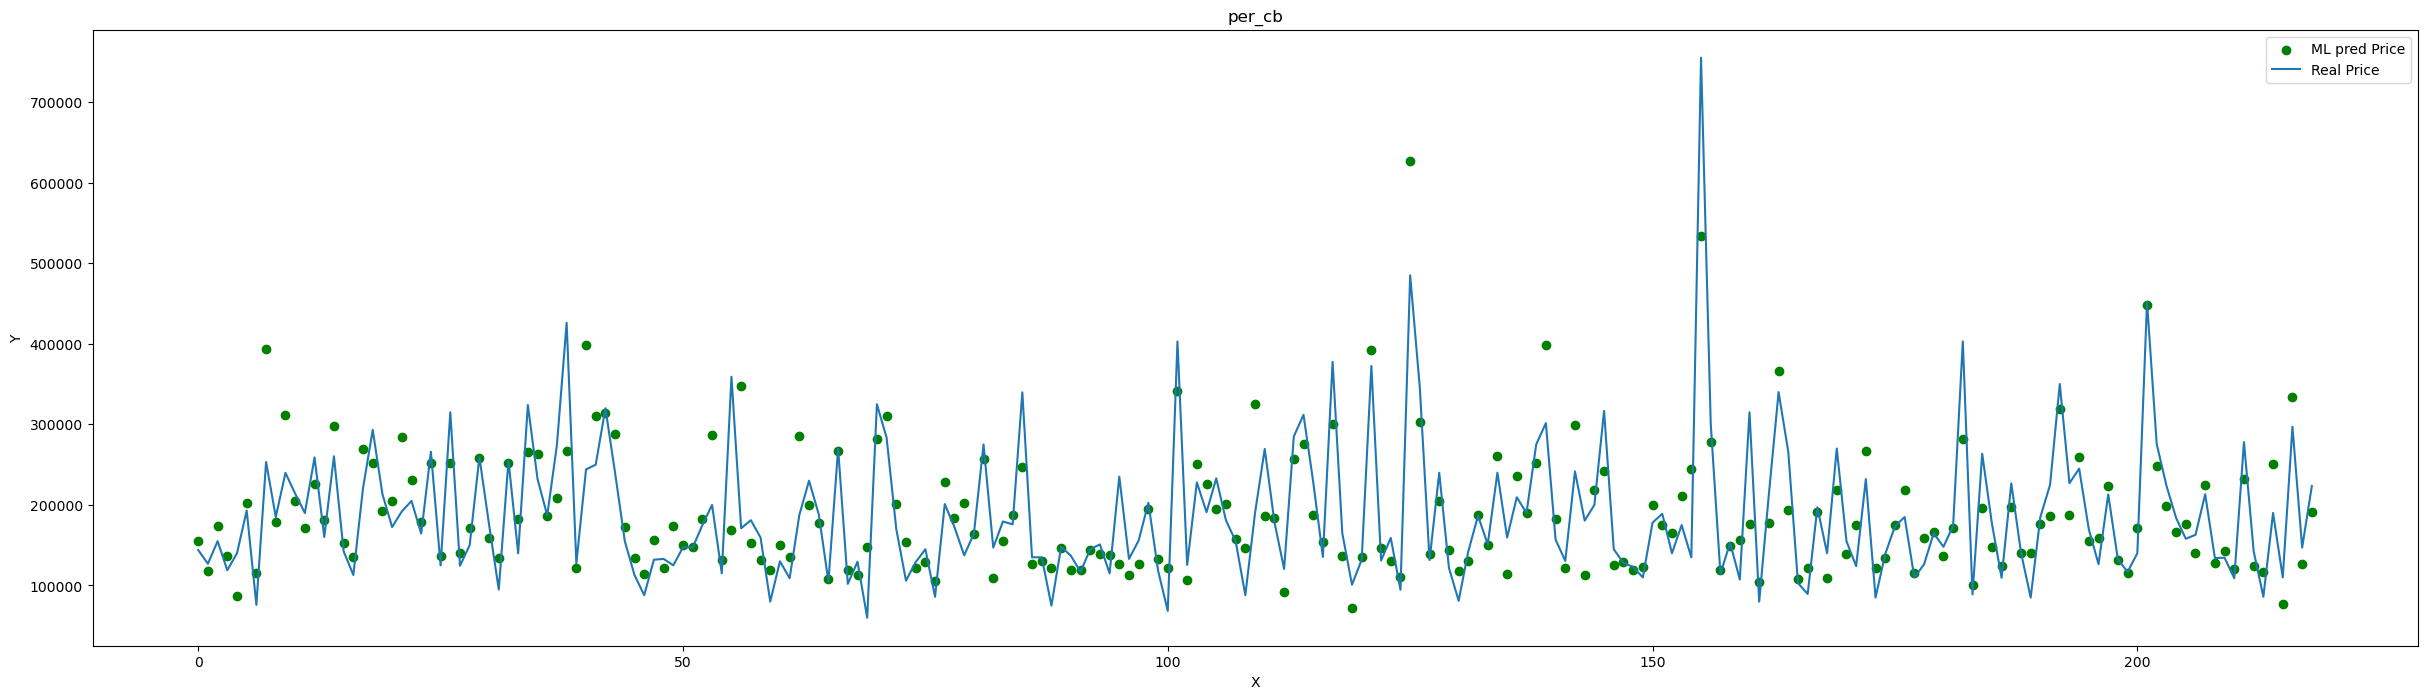

In [117]:
for i in range(len(ml_list)):
    x = list(range(len(ml_list[i])))
    y1 = ml_list[i]
    y2 = test_list[i]

    plt.figure(figsize=(30,8))
    plt.scatter(x, y1, label='ML pred Price',color="green")
    plt.plot(x, y2, label='Real Price')

    plt.title(name_list[i])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

    plt.show()